In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vision Warehouse Video Search

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/vijaykyr/genai-demos/blob/main/vision_warehouse/Vision_Warehouse_Video_Search.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
</table>

# Overview

[Vision Warehouse](https://cloud.google.com/vision-ai/docs/warehouse-overview) enables developers to integrate storage and AI-based search of unstructured media content into existing tools and applications.

In this notebook we will demonstrate the use of Vision Warehouse to store videos and then use AI powered multimodal search in which we can query based on the speech, text or images contained in the videos. Steps demonstrated include:


- Creating Vision Warehouse Corpus
- Uploading video assets from Google Cloud Storage
- Creating and Deploying Index
- Text-to-Image Search
- Speech Search
- OCR Search
- Image-to-Image Search

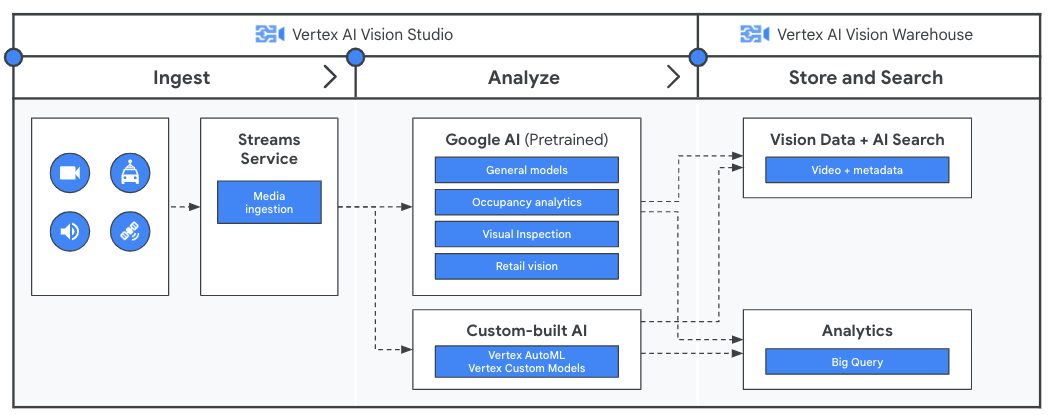

# Setup

## Install Dependencies (If Needed)

The list `packages` contains tuples of package import names and install names. If the import name is not found then the install name is used to install quitely for the current user.

In [ ]:
!gsutil cp gs://visionai-artifacts/visionai-0.0.6-py3-none-any.whl .

In [ ]:
# tuples of (import name, install name)
packages = [
    ('visionai','visionai-0.0.6-py3-none-any.whl'), # Vision Warehouse Client
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

## Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [ ]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Config

Specify the GCP project ID you want to use

In [ ]:
GCP_PROJECT_ID = "YOUR_PROJECT_ID"  # @param {type:"string"}
REGION = "us-central1" # only region currently supported

## Authenticate

If you are using Colab, you will need to authenticate yourself to GCP. The next cell will check if you are currently using Colab, and will start the authentication process.

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth as google_auth
    google_auth.authenticate_user(project_id=GCP_PROJECT_ID)

# If using local jupyter instance, uncomment and run:
# !gcloud auth login

PROJECT_NUMBER_STR = !gcloud projects describe $GCP_PROJECT_ID --format="value(projectNumber)"
PROJECT_NUMBER = int(PROJECT_NUMBER_STR[0])

## Enable API

In [ ]:
!gcloud config set project $GCP_PROJECT_ID
!gcloud services enable videointelligence.googleapis.com
!gcloud services enable visionai.googleapis.com

## Import Libraries

In [ ]:
import concurrent
import logging
import requests

from IPython.display import Image, HTML


from visionai.python.gapic.visionai import visionai_v1
from visionai.python.net import channel
from visionai.python.warehouse.transformer import \
    asset_indexing_transformer as ait
from visionai.python.warehouse.transformer import (ocr_transformer,
                                                   speech_transformer,
                                                   transformer_factory)
from visionai.python.warehouse.utils import (vod_asset, vod_corpus,
                                             vod_index_endpoint)

#Instantiate Vision Wareshouse Client
warehouse_endpoint = channel.get_warehouse_service_endpoint(channel.Environment['PROD'])
warehouse_client = visionai_v1.WarehouseClient(
    client_options={"api_endpoint": warehouse_endpoint}
)

# Config logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)
_logger = logging.getLogger("colab")

# Dataset
We'll use a small collection of videos stored in a public Google Cloud Storage bucket: [gs://cloud-samples-data/video](https://pantheon.corp.google.com/storage/browser/cloud-samples-data/video).

In [ ]:
GCS_FILES = [
    "gs://cloud-samples-data/video/animals.mp4",
    "gs://cloud-samples-data/video/googlework_short.mp4",
    "gs://cloud-samples-data/video/chicago.mp4",
    "gs://cloud-samples-data/video/JaneGoodall.mp4",
    "gs://cloud-samples-data/video/gbikes_dinosaur.mp4",
    "gs://cloud-samples-data/video/pizza.mp4",
]

# Create Corpus

A corpus is a container that holds media assets of the same type.

Vision Warehouse supports 3 types of content: streaming video, batch videos, and images.  We will create a batch video corpus.

In [ ]:
CORPUS_DISPLAY_NAME = "Video Demo" # @param {type: "string"}
CORPUS_DESCRIPTION = "Small collection of videos" # @param {type: "string"}

corpus_name = vod_corpus.create_corpus(
        warehouse_client,
        PROJECT_NUMBER,
        REGION,
        CORPUS_DISPLAY_NAME,
        CORPUS_DESCRIPTION,
    ).name
print("Corpus created:", corpus_name)

# Import Assets

Now we'll upload our video assets to the corpus

In [ ]:
%%time
# Creates an executor to upload and transform assets in parallel.
executor = concurrent.futures.ThreadPoolExecutor(max_workers=8)

new_asset_futures = []
for gcs_file in GCS_FILES:
    new_asset_futures.append(
        executor.submit(
            vod_asset.create_and_upload_asset,
            warehouse_client,
            gcs_file,
            corpus_name,
        )
    )
done_or_error, _ = concurrent.futures.wait(
    new_asset_futures, return_when="ALL_COMPLETED"
)
asset_names = []
for done_future in done_or_error:
    try:
        asset_names.append(done_future.result())
        _logger.info("Create and upload asset succeeded %s", done_future.result())
    except Exception as e:
        _logger.exception(e)

# Create Index

An index is a corpus-level resource that is a managed representation of analyzed assets and annotations. An index can be viewed as a dataset of embedding vectors and semantic restrictions that represents the meaning of the media content.

In [ ]:
%%time
INDEX_DISPLAY_NAME = "Video Demo Index" # @param {type: "string"}

# Creates index for the corpus.
index_name = vod_corpus.index_corpus(
    warehouse_client, corpus_name, INDEX_DISPLAY_NAME
)
print("Index created:", index_name)

# Create and Deploy Index Endpoint

Indexes by themselves are not accesible to client applications. To enable this we must create an index endpoint which provides a single point of access for sending search requests and then deploy the index to that endpoint. Note deploying the index may take up to 1 hour.

In [ ]:
%%time
INDEX_ENDPOINT_DISPLAY_NAME = "Video Demo Index Endpoint" # @param {type: "string"}

#Create Index Endpoint
index_endpoint_name = vod_index_endpoint.create_index_endpoint(
    warehouse_client,
    PROJECT_NUMBER,
    REGION,
    INDEX_ENDPOINT_DISPLAY_NAME,
).name


In [ ]:
%%time
#Deploy Index Endpoint
deploy_operation = warehouse_client.deploy_index(
    visionai_v1.DeployIndexRequest(
        index_endpoint=index_endpoint_name,
        deployed_index=visionai_v1.DeployedIndex(
            index=index_name,
        ),
    )
)
_logger.info("Wait for index to be deployed %s.", deploy_operation.operation.name)
# Wait for the deploy index operation. Depends on the data size to be
# indexed, the timeout may need to be increased.
deploy_operation.result(timeout=7200)
_logger.info("Index is deployed.")

# Run Transforms

Here we leverage the [Video Intelligence API](https://cloud.google.com/video-intelligence/docs) to do the following transforms:

- OCR Text Recognition
- Speech Recognition
- Image Embeddings

These transforms will allow us to query based on the speech, text or images contained in the videos.


In [ ]:
%%time
ocr_config = ocr_transformer.OcrTransformerInitConfig(
    corpus_name=corpus_name
)

speech_config = speech_transformer.SpeechTransformerInitConfig(
        corpus_name=corpus_name,
        language_code="en-US"
)

ml_config = transformer_factory.MlTransformersCreationConfig(
    run_embedding=True,
    speech_transformer_init_config=speech_config,
    ocr_transformer_init_config=ocr_config,
)

ml_transformers = transformer_factory.create_ml_transformers(
    warehouse_client, ml_config
)

# Creates indexing transformer to index assets.
asset_indexing_transformer = ait.AssetIndexingTransformer(warehouse_client, index_name)
# Runs the transformers for the assets.
futures = []

for asset_name in asset_names:
    futures.append(
        executor.submit(
            vod_asset.transform_single_asset,
            asset_name,
            ml_transformers,
            asset_indexing_transformer,
        )
    )
done_or_error, _ = concurrent.futures.wait(futures, return_when="ALL_COMPLETED")
for future in done_or_error:
    try:
        future.result()
    except Exception as e:
        _logger.exception(e)

all_transformers = ml_transformers + [asset_indexing_transformer]
for transformer in all_transformers:
    transformer.teardown()

# Search

## Util for Rendering Videos

In [ ]:
def display_results(results, top_k = 1):
  asset_names = [r.asset for r in results]
  uris = list(
      map(
          lambda asset_name: warehouse_client.generate_retrieval_url(
              visionai_v1.GenerateRetrievalUrlRequest(
                  name=asset_name,
              )
          ).signed_uri,
          asset_names,
      )
  )
  for i, asset in enumerate(results):
    if i >= top_k:
      break
    uri = warehouse_client.generate_retrieval_url(
            visionai_v1.GenerateRetrievalUrlRequest(name=asset.asset)).signed_uri
    start = asset.segment.start_time.timestamp()
    end = asset.segment.end_time.timestamp()

    video_html = """
    <video width="640" height="360" controls>
        <source src="{}#t={},{}" type="video/mp4">
    </video>
    """.format(uri, start, end)
    display(HTML(video_html))


## Text-to-Image Search

Here we use the search term 'dinosaur'. Vision Warehouse will search the video corpus for visuals of dinosaurs. Note instead of returning the whole video it returns just the relevant portion of the video containing the queried item

In [ ]:
search_response = warehouse_client.search_index_endpoint(
    visionai_v1.SearchIndexEndpointRequest(
        index_endpoint=index_endpoint_name,
        text_query="dinosaur",
    )
)
_logger.info("Search response: %s", search_response)
display_results(search_response)

## Speech Search

Now we will use the term 'zootopia' to demonstrate speech search. This is the name of a movie which our image embeddings are not likely to recognize, but since the word is said in the video it is recognized.

In [ ]:
cr = visionai_v1.Criteria(
    field="speech", text_array=visionai_v1.StringArray(txt_values=["zootopia"])
)
search_response = warehouse_client.search_index_endpoint(
    visionai_v1.SearchIndexEndpointRequest(
        index_endpoint=index_endpoint_name,
        criteria=[cr],
    )
)
_logger.info("Search response: %s", search_response)
display_results(search_response)

## OCR Search

Now we use 'zootopia' again, but this time specifying it as an OCR search. Notice it returns a different portion of the same video. This clip contains the part of the video where the text zootopia appears on the screen (towards end of clip), as opposed to the previous search which returned when the word was said.

In [ ]:
cr = visionai_v1.Criteria(
    field="text", text_array=visionai_v1.StringArray(txt_values=["zootopia"])
)
search_response = warehouse_client.search_index_endpoint(
    visionai_v1.SearchIndexEndpointRequest(
        index_endpoint=index_endpoint_name,
        criteria=[cr],
    )
)
_logger.info("Search response: %s", search_response)
display_results(search_response)

## Image-to-Image Search

Lastly we demonstrate searching by image. We'll use a pizza as the search image.

In [ ]:
SEARCH_IMG_URL = 'https://upload.wikimedia.org/wikipedia/commons/thumb/9/91/Pizza-3007395.jpg/800px-Pizza-3007395.jpg'
img_binary = b''.join(requests.get(SEARCH_IMG_URL).iter_content())
Image(SEARCH_IMG_URL)

In [ ]:
search_response = warehouse_client.search_index_endpoint(
    visionai_v1.SearchIndexEndpointRequest(
        index_endpoint=index_endpoint_name,
        image_query=visionai_v1.ImageQuery(
            input_image=img_binary,
        ),
    ),
)
_logger.info("Search response: %s", search_response)
display_results(search_response)

#Conclusion/Cleanup

You've now experienced AI Powered video search using vision warehouse! To clean up the resources you've created in this demo run the cell below.

In [ ]:
CLEAN_UP_ASSETS = False #@param {type:"boolean"}
CLEAN_UP_INDEX = False #@param {type:"boolean"}
CLEAN_UP_CORPUS = False #@param {type:"boolean"}

if CLEAN_UP_ASSETS:
    for asset_name in asset_names:
        warehouse_client.delete_asset(visionai_v1.DeleteAssetRequest(name=asset_name))
        _logger.info("Deleted asset %s", asset_name)

if CLEAN_UP_INDEX:
    undeploy_operation = warehouse_client.undeploy_index(
        visionai_v1.UndeployIndexRequest(index_endpoint=index_endpoint_name)
    )
    _logger.info(
        "Wait for index to be undeployed %s.",
        undeploy_operation.operation.name,
    )
    # Wait for the undeploy index operation.
    undeploy_operation.result(timeout=1800)
    _logger.info("Index is undeployed.")
    warehouse_client.delete_index(visionai_v1.DeleteIndexRequest(name=index_name))
    _logger.info("Deleted index %s", index_name)
    warehouse_client.delete_index_endpoint(
        visionai_v1.DeleteIndexEndpointRequest(name=index_endpoint_name)
    )
    _logger.info("Deleted index endpoint %s", index_endpoint_name)

if CLEAN_UP_CORPUS:
    warehouse_client.delete_corpus(visionai_v1.DeleteCorpusRequest(name=corpus_name))
    _logger.info("Deleted corpus %s", corpus_name)